## Probabilistic programming from scratch 1

Following the [Oriole](https://www.safaribooksonline.com/oriole/probabilistic-programming-from-scratch-1-a-b-testing-with-approximate-bayesian-computation#) by 
Mike Lee Williams from Fast Forward Labs

### Results of A/B test that was run

In [6]:
n_visitors_a = 100  # number of visitors shown layout A
n_conv_a = 4        # number of vistors shown layout A who converted (4%)

n_visitors_b = 40  
n_conv_b = 2

### Setting up the simulation

In [2]:
def estimate_conversion(n_visitors, n_conv, trial_conversion, n_estimates=5000):
    """
    Return n_estimates estimates of the conversion fraction of a layout 
    that received n_vistors, n_conv of which converted
    
    Alternatively phrased as with a trial conversion probability of p, how many times 
    do we see the conversion fraction that we observed from the one time we actually 
    ran the experiment?
    """
    
    i = 0
    estimates = []
    while i < n_estimates:
        # Generate a trial conversion probability
        p = trial_conversion()
        # Simulate the conversion with this probability
        n_sim = simulate_conversion(p, n_visitors)
        if n_conv == n_sim:
            estimates.append(p)
            # Everytime we match, then the estimate counter is increased
            i += 1
    return estimates
        

In the previous function, we will get n_estimates estimates of a conversion probability that gives us the conversions that we obtained in our actual experiment

In [3]:
import random

def trial_conversion_a():
    """
    Return a random probability of conversion between 0 and 1
    """
    return random.random()

trial_conversion_a()

0.760144372501612

In [4]:
def simulate_conversion(p, n_visitors):
    """
    Returns the number of visitors who convert given a conversion fraction p
    """
    outcomes = [random.random() < p for _ in range(n_visitors)]
    return sum(outcomes)

simulate_conversion(0.5, 10)

6

This works as follows - for each visitor, generate a random number and if that number is less than the conversion probability, then the visitor converted. Kind of like what you do with accepting a move in Monte Carlo simulations

### What does the simulation tell us?

In [7]:
a_estimates = estimate_conversion(n_visitors_a, n_conv_a, trial_conversion_a)
len(a_estimates)

5000

#### Histogram

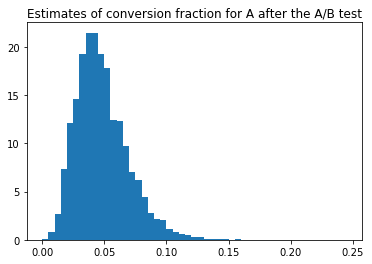

In [8]:
% matplotlib inline
import matplotlib.pyplot as plt

# 50 bins between 0 and 0.25 - our measured conversion probabilities are smaller than this
abbins = [i/200.0 for i in range(50)]

plt.hist(a_estimates, bins=abbins, normed=True)
plt.title('Estimates of conversion fraction for A after the A/B test')

In [11]:
def trial_conversion_b():
    """
    Return a random number around 0.06 +/- 0.02
    """
    while True:
        x = random.normalvariate(mu=0.06, sigma = 0.02)
        if 0 <= x <=1:
            return x

trial_conversion_b()

0.08407945319142177

Here we are incorporating prior belief into the conversion probability of B - we assume it is between 0.04 and 0.08

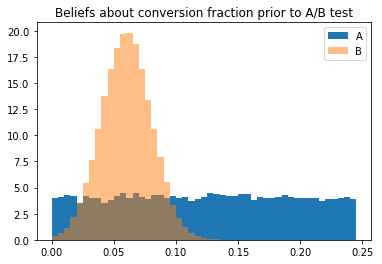

In [12]:
trial_as = [trial_conversion_a() for _ in range(100000)]
trial_bs = [trial_conversion_b() for _ in range(100000)]

plt.hist(trial_as, bins=abbins, label='A',normed=True)
plt.hist(trial_bs, bins=abbins, label='B',alpha=0.5, normed=True)
plt.title('Beliefs about conversion fraction prior to A/B test')
plt.legend()

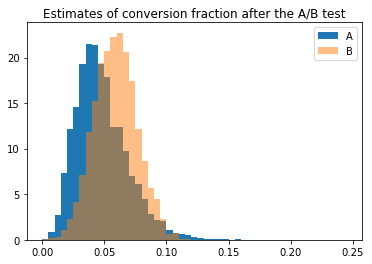

In [14]:
b_estimates = estimate_conversion(n_visitors_b,n_conv_b, trial_conversion_b)
plt.hist(a_estimates, bins=abbins, label='A',normed=True)
plt.hist(b_estimates, bins=abbins, label='B',alpha=0.5,normed=True)
plt.title('Estimates of conversion fraction after the A/B test')
plt.legend()

Shows that estimate for conversion from B is between 0.05 and 0.06 after incorporating our data

### Comparisons

In [15]:
b_better = [b > a for a, b in zip(a_estimates, b_estimates)]

In [16]:
print(b_better[:10])

[True, True, True, True, True, True, True, False, False, True]


In [17]:
print(sum(b_better)/len(b_better))

0.6786


The analysis tells us that about the probability of layout B being better is 0.68. Depending on the cost of the decisions involved, this maybe enough to proceed. 

### Exercises

#### What is the probability that the conversion of A is > 0.06 ?

In [19]:
a_gt_6pct = [a > 0.06 for a in a_estimates]
print(sum(a_gt_6pct)/len(a_gt_6pct))

0.2532


About 25%

#### What is the probability that b is 1% better than A? 

In [20]:
b_better_1pct = [b > (a + 0.01) for a , b in zip(a_estimates, b_estimates)]
print(sum(b_better_1pct)/len(b_better_1pct))

0.538


About 54%

#### What is the most likely value of the conversion probability of B? 

In [24]:
# Technically one should look at the median and not the mean
print(sum(b_estimates)/len(b_estimates))

0.05909479413316146


In [25]:
import numpy as np
median_b = np.median(np.asarray(b_estimates))
print(median_b)

0.0589229105394


Median is slightly lower than the mean, but they are much closer to 0.06 than to 0.05 which is what our measurement obtained